# Evaluation zero-shot in-silico submissions for protein engineering tournament

*   Take as input submission files
*   Compute the performance of each team for each property in each event
*   Merge them all into a summary CSV


## Preamble

In [1]:
%reload_ext jupyter_black

In [3]:
import pandas as pd
from pathlib import Path
import plotnine as p9
from sklearn.metrics import f1_score, accuracy_score

## Analysis

Let's create table with the source data

In [84]:
datasets = []
for f in Path("input").glob("*/*.csv"):
    dd = pd.read_csv(f)
    dd = dd[[c for c in dd.columns if c not in {"Design id", "Design", "mutant"}]]
    datasets.append(
        dd.melt(
            id_vars=["mutated_sequence"], var_name="target", value_name="truth"
        ).assign(
            dataset=f.name.partition(" ")[0].removesuffix(".csv"),
        )
    )
truth = pd.concat(datasets).dropna()
truth.to_csv("output/truth.csv.gz")

Let's create a table with predictions

In [85]:
dataset_to_target = (
    truth.groupby("dataset")
    .apply(lambda d: set(d.target.unique()), include_groups=False)
    .to_dict()
)

In [86]:
datasets = []
for f in Path("input").glob("*/predictions/*.csv"):
    dd = pd.read_csv(f)
    dataset = dataset = f.parent.parent.name.partition(" ")[0].removesuffix(".csv")
    dd = dd[
        [
            c
            for c in dd.columns
            if c not in {"Expression_continuous_score", "mutant", "Unnamed: 0"}
        ]
    ]
    assert set(dd.columns) == dataset_to_target[dataset] | {
        "mutated_sequence"
    }, f"{f.name} -- {set(dd.columns)}"
    datasets.append(
        dd.melt(
            id_vars=["mutated_sequence"], var_name="target", value_name="prediction"
        ).assign(team=f.name.removesuffix(".csv"), dataset=dataset)
    )
subm = pd.concat(datasets).dropna()

Marks sequence lack a suffix of HHHHHH for some reason

In [87]:
marks_seq = subm.loc[
    lambda d: (d.team == "marks-lab") & (d.dataset == "Aminotransferase"),
    "mutated_sequence",
]

In [88]:
subm.loc[
    lambda d: (d.team == "marks-lab") & (d.dataset == "Aminotransferase"),
    "mutated_sequence",
] = (
    marks_seq + "HHHHHH"
)

In [89]:
comb = subm.merge(
    truth, on=["mutated_sequence", "target", "dataset"], how="left", validate="m:1"
)

/Users/henning/.virtualenvs/pet-pilot/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4503 rows containing missing values.


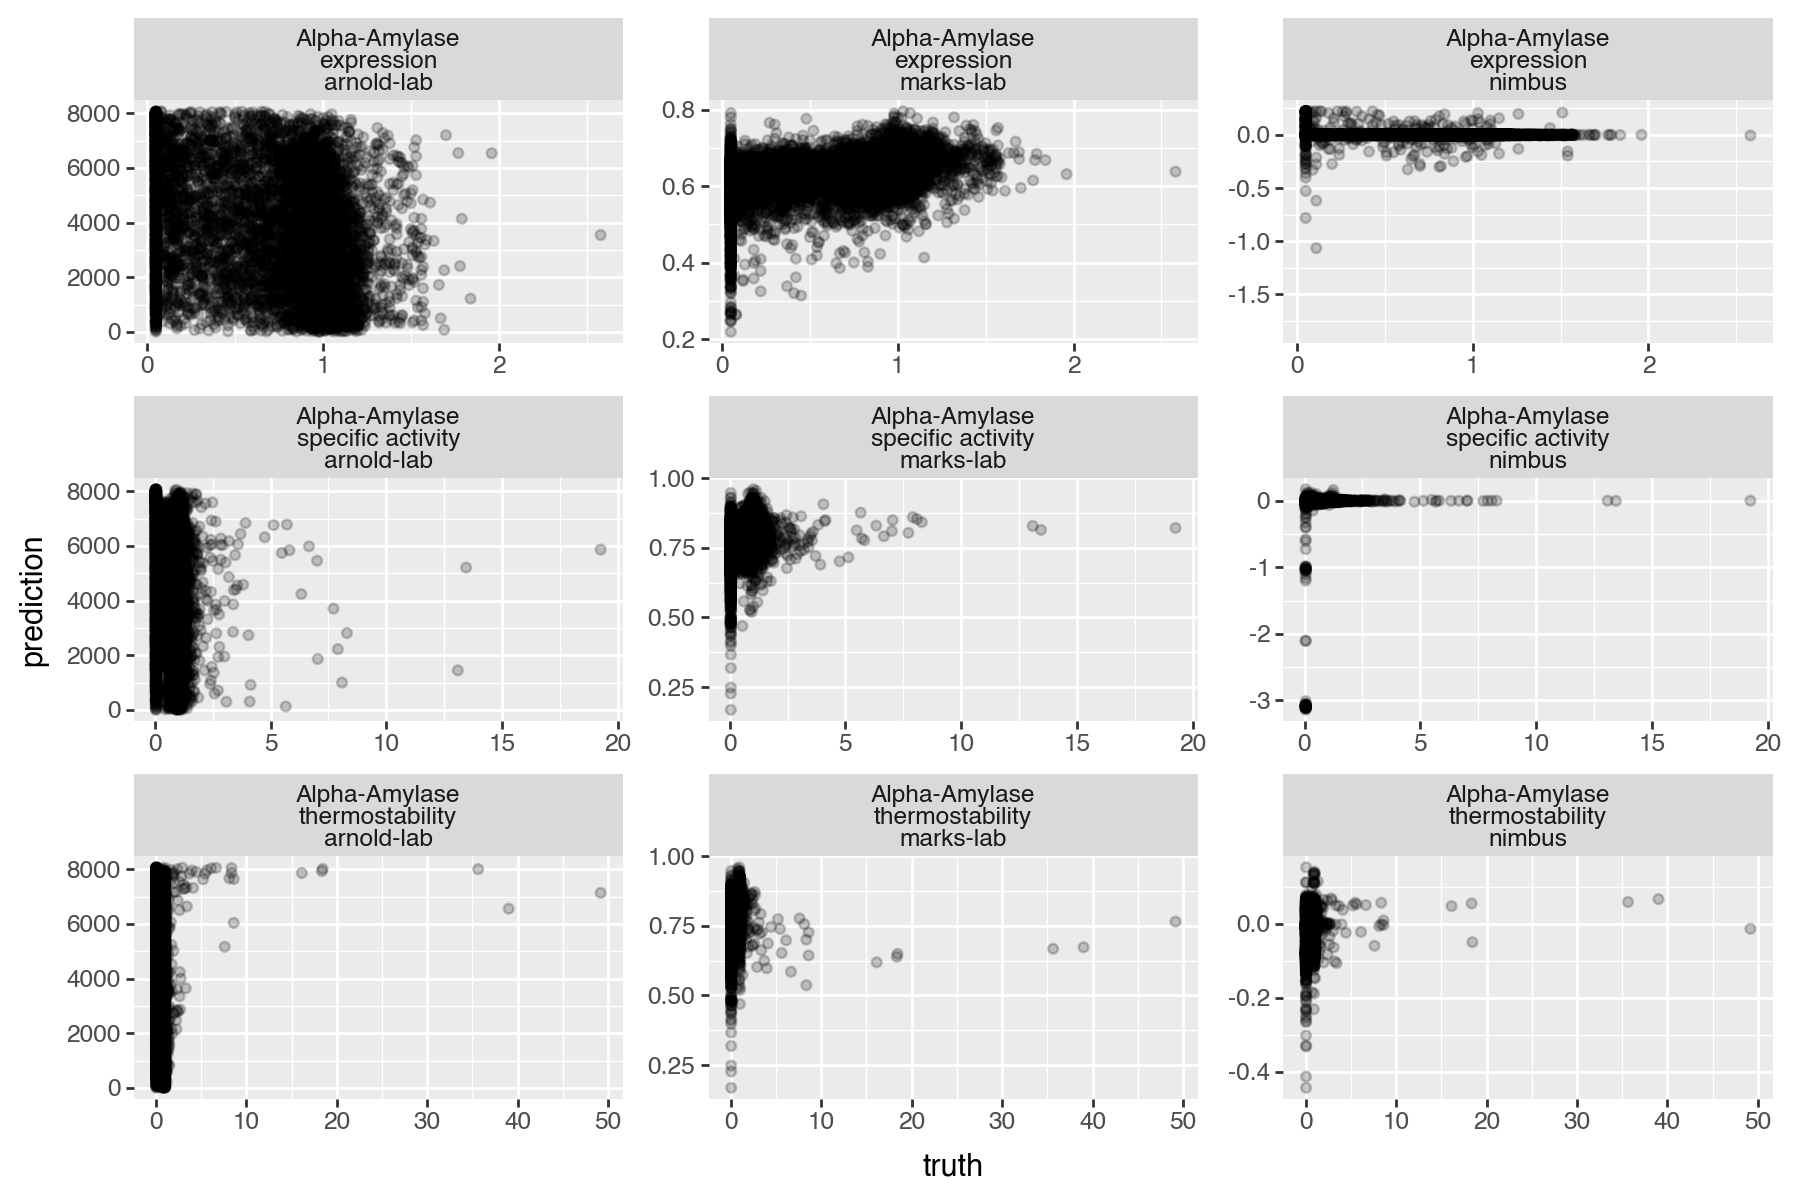

In [90]:
p9.options.set_option("figure_size", (9, 6))
(
    p9.ggplot(comb.query("dataset == 'Alpha-Amylase'"), p9.aes("truth", "prediction"))
    + p9.geom_point(alpha=0.2)
    + p9.facet_wrap("~ dataset + target + team", scales="free")
)

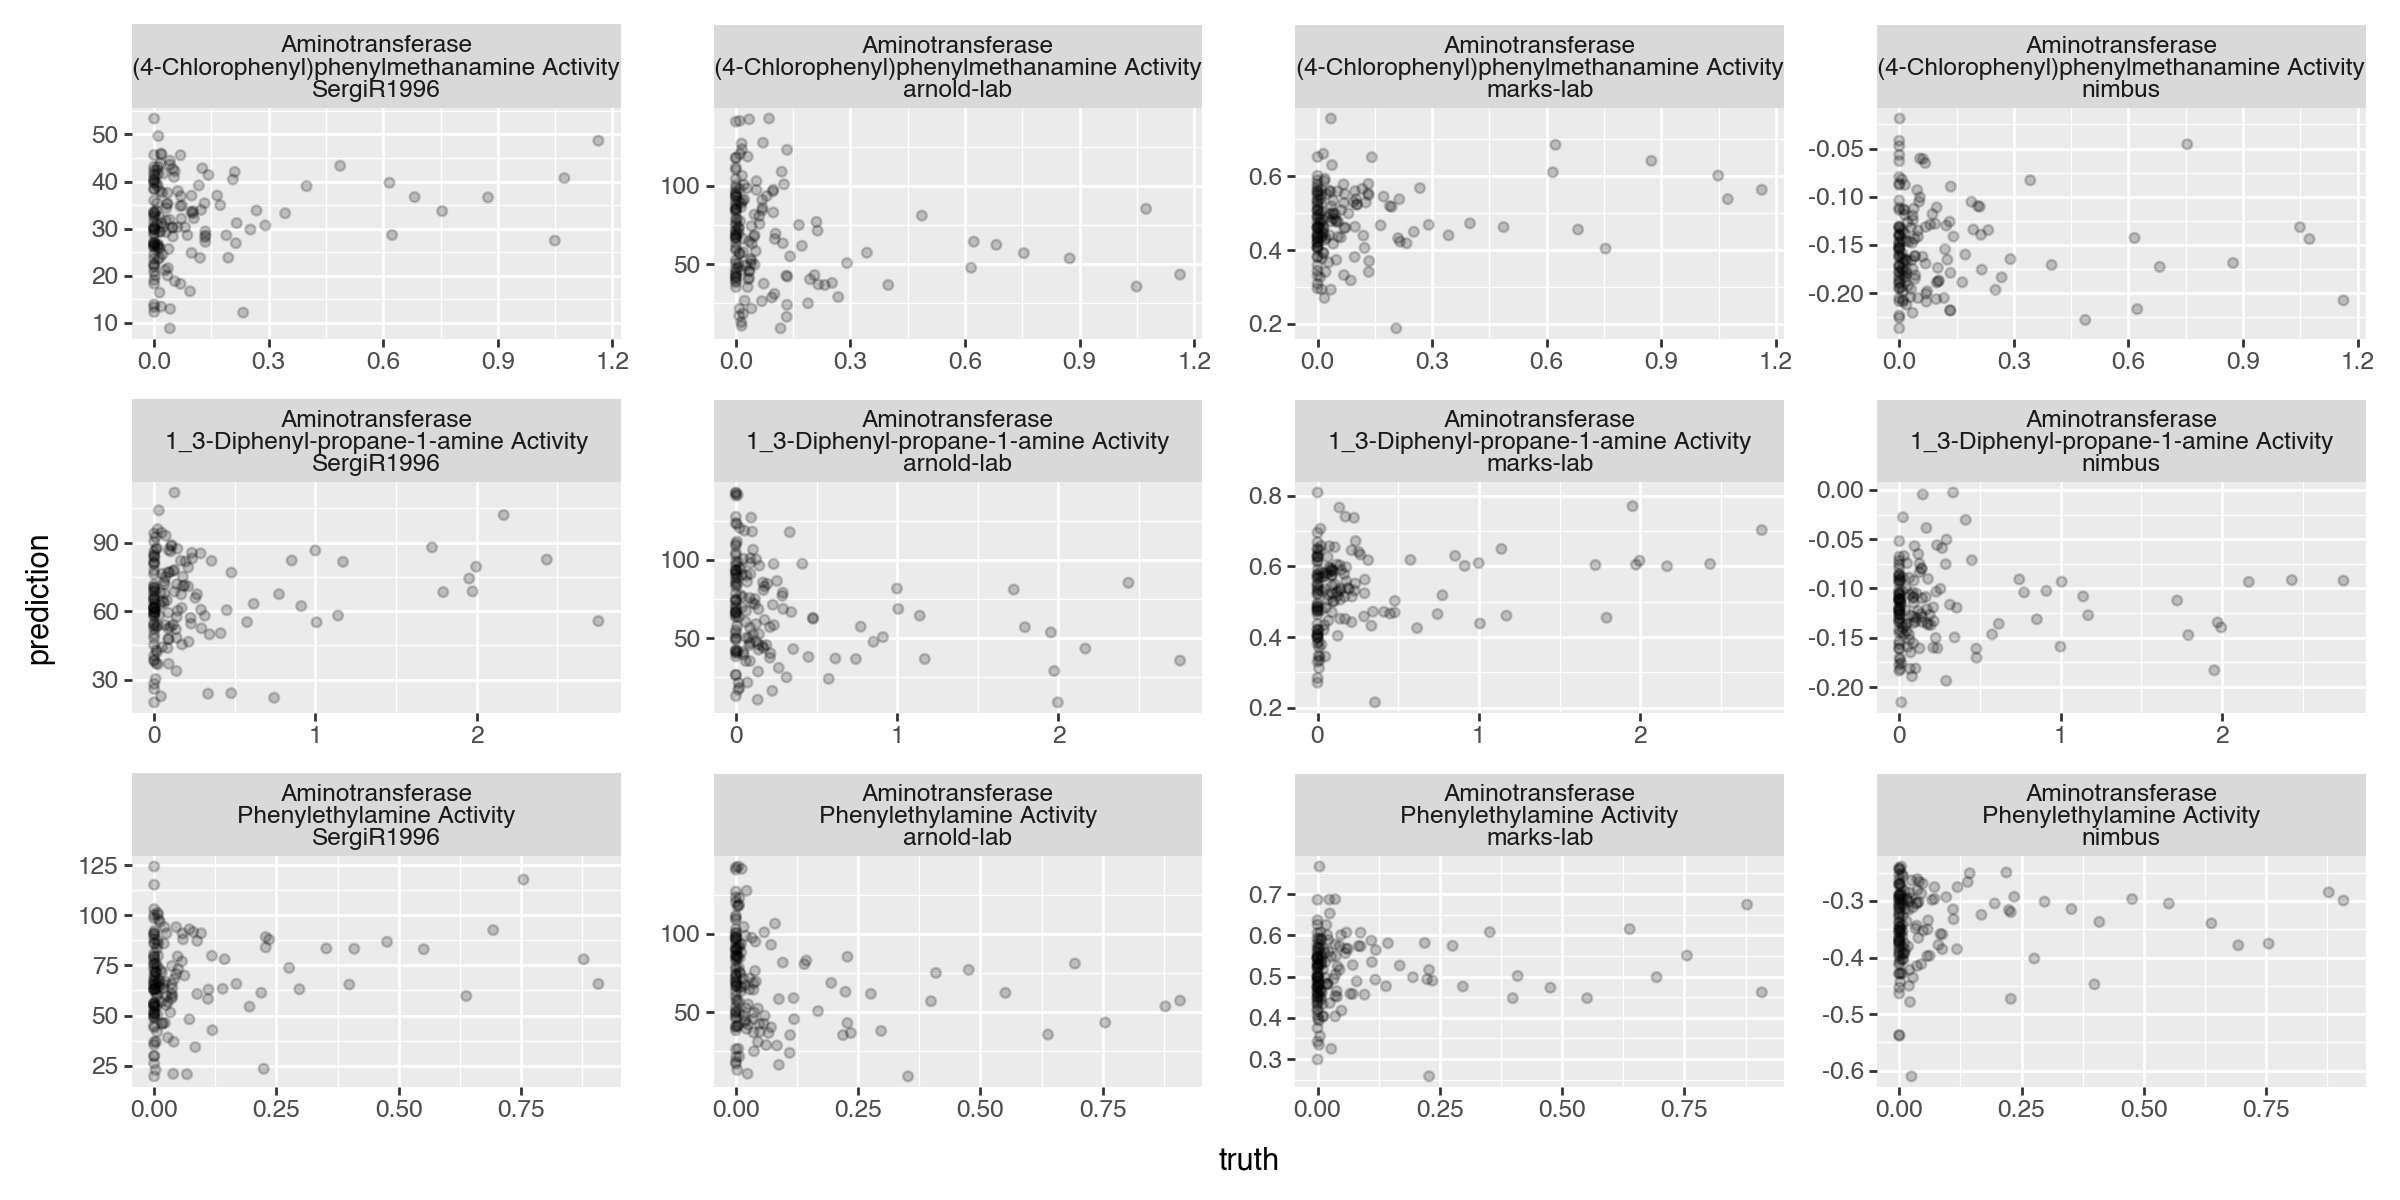

In [91]:
p9.options.set_option("figure_size", (12, 6))
(
    p9.ggplot(
        comb.query("dataset == 'Aminotransferase'"), p9.aes("truth", "prediction")
    )
    + p9.geom_point(alpha=0.2)
    + p9.facet_wrap("~ dataset + target + team", scales="free")
)

In [92]:
comb.to_csv("output/truth-and-predictions.csv.gz")

In [93]:
spearman = (
    comb.loc[lambda d: d.dataset != "Xylanase"]
    .drop(columns=["mutated_sequence"])
    .groupby(["dataset", "target", "team"])
    .corr(method="spearman")
    .loc[(slice(None), slice(None), slice(None), "truth"), ["prediction"]]
    .reset_index(level=3, drop=True)
)

In [94]:
r1 = (
    spearman.reset_index()
    .drop(columns=["target"])
    .groupby(["dataset", "team"])
    .mean()
    .rename(columns={"prediction": "Average Spearman"})
)

The Xylanase dataset was classification and should be done with F1 score. 

In [95]:
xyl = comb.query("dataset == 'Xylanase'").assign(
    truth=lambda d: pd.Categorical(d.truth).codes,
    prediction=lambda d: pd.Categorical(d.prediction).codes,
)

In [96]:
r2 = (
    xyl.groupby(["dataset", "team"])
    .apply(
        lambda d: pd.DataFrame(
            {
                "F1 Score (Weighted)": [
                    f1_score(
                        y_true=d.truth.values,
                        y_pred=d.prediction.values,
                        average="weighted",
                    )
                ],
                "Accuracy": [
                    accuracy_score(y_true=d.truth.values, y_pred=d.prediction.values)
                ],
            },
        ),
        include_groups=False,
    )
    .reset_index(level=2, drop=True)
)

In [97]:
r12 = pd.concat([r1, r2])
r12.to_csv("../doc/zero-shot-board.csv")
r12

Average Spearman  F1 Score (Weighted)  Accuracy
dataset          team                                                        
Alpha-Amylase    arnold-lab          -0.261052                  NaN       NaN
                 marks-lab            0.401284                  NaN       NaN
                 nimbus               0.126598                  NaN       NaN
Aminotransferase SergiR1996           0.125804                  NaN       NaN
                 arnold-lab          -0.283016                  NaN       NaN
                 marks-lab            0.162651                  NaN       NaN
                 nimbus               0.019337                  NaN       NaN
Xylanase         SergiR1996                NaN             0.275443  0.203980
                 arnold-lab                NaN             0.186925  0.199005
                 marks-lab                 NaN             0.641055  0.567164
                 nimbus                    NaN             0.560650  0.497512
                 tum-rostlab               NaN             0.197904  0.174129